In [41]:
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import torch.optim as optim
import torch.nn.modules.loss 
import os
from os import listdir

In [42]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

kaggle\makTrain
kaggle\validation
kaggle\test
kaggle\make
kaggle\reverse
{'G11': 0, 'G15': 1, 'G17': 2, 'G19': 3, 'G32': 4, 'G34': 5, 'G48': 6, 'G49': 7}
{'G11': 0, 'G15': 1, 'G17': 2, 'G19': 3, 'G32': 4, 'G34': 5, 'G48': 6, 'G49': 7}


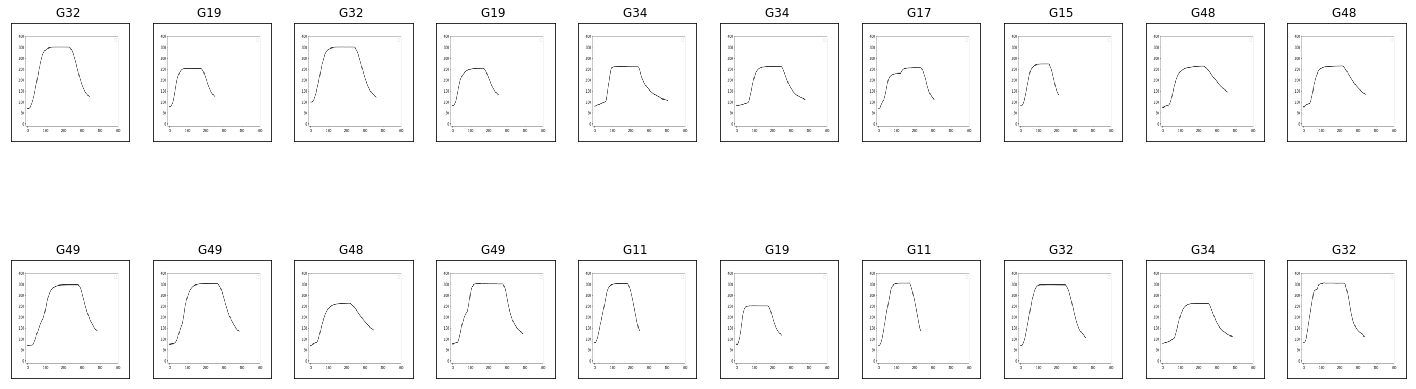

In [43]:
##############
# dataResize #
##############

PATH_train="kaggle/makTrain"
PATH_val="kaggle/validation"
PATH_test="kaggle/test"
PATH_make="kaggle/make"
PATH_reverse="kaggle/reverse"

TRAIN = Path(PATH_train)
VALID = Path(PATH_val)
TEST = Path(PATH_test)
MAKE = Path(PATH_make)
REVERSE = Path(PATH_reverse)

print(TRAIN)
print(VALID)
print(TEST)
print(MAKE)
print(REVERSE)

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# learning rate
LR = 0.01

# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

make_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

reverse_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
train_data = datasets.ImageFolder(TRAIN, transform=train_transforms)
valid_data = datasets.ImageFolder(VALID,transform=valid_transforms)
test_data = datasets.ImageFolder(TEST, transform=test_transforms)
make_data = datasets.ImageFolder(MAKE, transform=make_transforms)
reverse_data = datasets.ImageFolder(REVERSE, transform=make_transforms)

print(train_data.class_to_idx)
print(valid_data.class_to_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,  num_workers=num_workers)
make_loader = torch.utils.data.DataLoader(make_data, batch_size=batch_size,  num_workers=num_workers)
reverse_loader = torch.utils.data.DataLoader(reverse_data, batch_size=batch_size,  num_workers=num_workers)

images,labels=next(iter(train_loader))
images.shape,labels.shape

classes = ['G11','G15','G17','G19','G32','G34','G48', 'G49']
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])


def denormalize(image):
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) #Changing from 3x224x224 to 224x224x3
  image = torch.clamp(image,0,1)
  return image

# helper function to un-normalize and display an image
def imshow(img):
    img = denormalize(img) 
    plt.imshow(img)
    
dataiter = iter(train_loader)
images, labels = dataiter.next()

#convert images to numpy for display

#plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ".format( classes[labels[idx]]))
    

In [44]:
##########
# Module #
##########

class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution 1 , input_shape=(3,224,224)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) #output_shape=(16,220,220) #(224-5+1)/1 #(weigh-kernel+1)/stride 無條件進位
        self.relu1 = nn.ReLU() # activation
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,110,110) #(220/2)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #output_shape=(32,106,106)
        self.relu2 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,53,53)
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=0) #output_shape=(16,51,51)
        self.relu3 = nn.ReLU() # activation
        # Max pool 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,25,25)
        # Convolution 4
        self.cnn4 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=0) #output_shape=(8,23,23)
        self.relu4 = nn.ReLU() # activation
        # Max pool 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) #output_shape=(8,11,11)
        # Fully connected 1 ,#input_shape=(8*12*12)
        self.fc1 = nn.Linear(8 * 11 * 11, 512) 
        self.relu5 = nn.ReLU() # activation
        self.fc2 = nn.Linear(512, 8) 
        self.output = nn.Softmax(dim=1)
        
    
    def forward(self, x):
        out = self.cnn1(x) # Convolution 1
        out = self.relu1(out)
        out = self.maxpool1(out)# Max pool 1
        out = self.cnn2(out) # Convolution 2
        out = self.relu2(out) 
        out = self.maxpool2(out) # Max pool 2
        out = self.cnn3(out) # Convolution 3
        out = self.relu3(out)
        out = self.maxpool3(out) # Max pool 3
        out = self.cnn4(out) # Convolution 4
        out = self.relu4(out)
        out = self.maxpool4(out) # Max pool 4
        out = out.view(out.size(0), -1) # last CNN faltten con. Linear NN
        out = self.fc1(out) # Linear function (readout)
        out = self.fc2(out)
        out = self.output(out)

        return out

In [45]:
# Set model
model = CNN_Model()
# Test GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
# optimizer function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# loss function
criterion = nn.CrossEntropyLoss()
# number of epochs to train the model
if train_on_gpu:
    model.cuda()
n_epochs = 50
valid_loss_min = np.Inf # track change in validation loss

CUDA is available!  Training on GPU ...


In [17]:
############
# Training #
############
for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch))
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in tqdm(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data+1)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    #train_losses.append(train_loss/len(train_loader.dataset))
    #valid_losses.append(valid_loss.item()/len(valid_loader.dataset)
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'maknet1.pth')
        valid_loss_min = valid_loss

running epoch: 1


	Training Loss: 2.073650 	Validation Loss: 2.057285
Validation loss decreased (inf --> 2.057285).  Saving model ...
running epoch: 2


	Training Loss: 2.052376 	Validation Loss: 2.037848
Validation loss decreased (2.057285 --> 2.037848).  Saving model ...
running epoch: 3


	Training Loss: 2.038816 	Validation Loss: 2.034036
Validation loss decreased (2.037848 --> 2.034036).  Saving model ...
running epoch: 4


	Training Loss: 2.035907 	Validation Loss: 2.032441
Validation loss decreased (2.034036 --> 2.032441).  Saving model ...
running epoch: 5


	Training Loss: 2.034034 	Validation Loss: 2.028565
Validation loss decreased (2.032441 --> 2.028565).  Saving model ...
running epoch: 6


	Training Loss: 2.026441 	Validation Loss: 2.022649
Validation loss decreased (2.028565 --> 2.022649).  Saving model ...
running epoch: 7


	Training Loss: 2.022151 	Validation Loss: 2.009427
Validation loss decreased (2.022649 --> 2.009427).  Saving model ...
running epoch: 8


	Training Loss: 2.003416 	Validation Loss: 1.991545
Validation loss decreased (2.009427 --> 1.991545).  Saving model ...
running epoch: 9


	Training Loss: 1.976151 	Validation Loss: 1.950970
Validation loss decreased (1.991545 --> 1.950970).  Saving model ...
running epoch: 10


	Training Loss: 1.925816 	Validation Loss: 1.879083
Validation loss decreased (1.950970 --> 1.879083).  Saving model ...
running epoch: 11


	Training Loss: 1.835787 	Validation Loss: 1.768110
Validation loss decreased (1.879083 --> 1.768110).  Saving model ...
running epoch: 12


	Training Loss: 1.705982 	Validation Loss: 1.615097
Validation loss decreased (1.768110 --> 1.615097).  Saving model ...
running epoch: 13


	Training Loss: 1.560470 	Validation Loss: 1.502152
Validation loss decreased (1.615097 --> 1.502152).  Saving model ...
running epoch: 14


	Training Loss: 1.480174 	Validation Loss: 1.456819
Validation loss decreased (1.502152 --> 1.456819).  Saving model ...
running epoch: 15


	Training Loss: 1.450130 	Validation Loss: 1.440408
Validation loss decreased (1.456819 --> 1.440408).  Saving model ...
running epoch: 16


	Training Loss: 1.437103 	Validation Loss: 1.434372
Validation loss decreased (1.440408 --> 1.434372).  Saving model ...
running epoch: 17


	Training Loss: 1.432582 	Validation Loss: 1.430503
Validation loss decreased (1.434372 --> 1.430503).  Saving model ...
running epoch: 18


	Training Loss: 1.435716 	Validation Loss: 1.430828
running epoch: 19


	Training Loss: 1.430528 	Validation Loss: 1.431906
running epoch: 20


	Training Loss: 1.429319 	Validation Loss: 1.427608
Validation loss decreased (1.430503 --> 1.427608).  Saving model ...
running epoch: 21


	Training Loss: 1.427528 	Validation Loss: 1.427058
Validation loss decreased (1.427608 --> 1.427058).  Saving model ...
running epoch: 22


	Training Loss: 1.426586 	Validation Loss: 1.426372
Validation loss decreased (1.427058 --> 1.426372).  Saving model ...
running epoch: 23


	Training Loss: 1.426464 	Validation Loss: 1.426117
Validation loss decreased (1.426372 --> 1.426117).  Saving model ...
running epoch: 24


	Training Loss: 1.427405 	Validation Loss: 1.425719
Validation loss decreased (1.426117 --> 1.425719).  Saving model ...
running epoch: 25


	Training Loss: 1.425835 	Validation Loss: 1.425715
Validation loss decreased (1.425719 --> 1.425715).  Saving model ...
running epoch: 26


	Training Loss: 1.425623 	Validation Loss: 1.425108
Validation loss decreased (1.425715 --> 1.425108).  Saving model ...
running epoch: 27


	Training Loss: 1.425162 	Validation Loss: 1.425055
Validation loss decreased (1.425108 --> 1.425055).  Saving model ...
running epoch: 28


	Training Loss: 1.424627 	Validation Loss: 1.424614
Validation loss decreased (1.425055 --> 1.424614).  Saving model ...
running epoch: 29


	Training Loss: 1.424725 	Validation Loss: 1.424599
Validation loss decreased (1.424614 --> 1.424599).  Saving model ...
running epoch: 30


	Training Loss: 1.424412 	Validation Loss: 1.424711
running epoch: 31


	Training Loss: 1.424400 	Validation Loss: 1.424190
Validation loss decreased (1.424599 --> 1.424190).  Saving model ...
running epoch: 32


	Training Loss: 1.424159 	Validation Loss: 1.424034
Validation loss decreased (1.424190 --> 1.424034).  Saving model ...
running epoch: 33


	Training Loss: 1.423854 	Validation Loss: 1.424134
running epoch: 34


	Training Loss: 1.423845 	Validation Loss: 1.423750
Validation loss decreased (1.424034 --> 1.423750).  Saving model ...
running epoch: 35


	Training Loss: 1.423761 	Validation Loss: 1.423669
Validation loss decreased (1.423750 --> 1.423669).  Saving model ...
running epoch: 36


	Training Loss: 1.423631 	Validation Loss: 1.423698
running epoch: 37


	Training Loss: 1.423956 	Validation Loss: 1.423484
Validation loss decreased (1.423669 --> 1.423484).  Saving model ...
running epoch: 38


	Training Loss: 1.423536 	Validation Loss: 1.423455
Validation loss decreased (1.423484 --> 1.423455).  Saving model ...
running epoch: 39


	Training Loss: 1.423506 	Validation Loss: 1.423355
Validation loss decreased (1.423455 --> 1.423355).  Saving model ...
running epoch: 40


	Training Loss: 1.423327 	Validation Loss: 1.423456
running epoch: 41


	Training Loss: 1.423325 	Validation Loss: 1.423255
Validation loss decreased (1.423355 --> 1.423255).  Saving model ...
running epoch: 42


	Training Loss: 1.423287 	Validation Loss: 1.423147
Validation loss decreased (1.423255 --> 1.423147).  Saving model ...
running epoch: 43


	Training Loss: 1.423324 	Validation Loss: 1.423402
running epoch: 44


	Training Loss: 1.423078 	Validation Loss: 1.423105
Validation loss decreased (1.423147 --> 1.423105).  Saving model ...
running epoch: 45


	Training Loss: 1.423131 	Validation Loss: 1.423122
running epoch: 46


	Training Loss: 1.422999 	Validation Loss: 1.423047
Validation loss decreased (1.423105 --> 1.423047).  Saving model ...
running epoch: 47


	Training Loss: 1.422989 	Validation Loss: 1.423032
Validation loss decreased (1.423047 --> 1.423032).  Saving model ...
running epoch: 48


	Training Loss: 1.422983 	Validation Loss: 1.422969
Validation loss decreased (1.423032 --> 1.422969).  Saving model ...
running epoch: 49


	Training Loss: 1.422997 	Validation Loss: 1.422911
Validation loss decreased (1.422969 --> 1.422911).  Saving model ...
running epoch: 50


	Training Loss: 1.422963 	Validation Loss: 1.422927


In [18]:
#################
# Test Function #
#################

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [46]:
#####################
# Classify Function #
#####################
def classify(loaders, model, criterion, use_cuda):
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        #print classes
        lis.append(pred)

In [20]:
###########
# Testing #
###########
setNetPath = 'maknet1.pth'
model = CNN_Model()
model.load_state_dict(torch.load(setNetPath))
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  Testing on CPU ...')
else:
    model.cuda()
    print('CUDA is available!  Testing on GPU ...')
test(test_loader, model, criterion, use_cuda)

CUDA is available!  Testing on GPU ...
Test Loss: 1.567639
Test Accuracy: 70% (1217/1727)


In [10]:
###############
# Classifying #
###############
lis = []
setNetPath = 'net/net1.pth'
model = CNN_Model()
model.load_state_dict(torch.load(setNetPath))
use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available.  Classifying on CPU ...')
else:
    model.cuda()
    print('CUDA is available!  Classifying on GPU ...')
classify(make_loader, model, criterion, use_cuda)
print('Classifying is done!')
path = 'kaggle/make/'
ary = []
fcount = [0]
count = []
for i in range(8):
    count.append(0)

for i in lis:
    for j in i:
        for k in j:
            ary.append(k)
t = 1
makeDirs = listdir(path)
for dirs in makeDirs:
    files = listdir(path+dirs)
    fcount.append(len(files)+fcount[t-1])
    t+=1
t = 0
makeDirs = listdir(path)
for k in range(len(makeDirs)):
    t+=1
    tmp = 0
    cla = 0
    for j in range(8):
        count[j] = 0
    for i in range(fcount[t-1], fcount[t]):
        count[ary[i]]+=1
    for i in range(8):
        if count[i] > tmp:
            tmp = count[i]
            cla = i
    print(makeDirs[k]+': '+classes[cla])

CUDA is available!  Classifying on GPU ...
Classifying is done!
01: G11
02: G11
03: G15
04: G15
05: G15
06: G15
07: G15
08: G15
09: G17
10: G17
11: G19
12: G19
13: G32
14: G32
15: G32
16: G32
17: G32
18: G32
19: G34
20: G34
21: G34
22: G34
23: G34
24: G34
25: G48
26: G48
27: G48
28: G48
29: G48
30: G48
31: G49
32: G49
33: G49
34: G49
35: G49
36: G49


In [49]:
###########
# Reverse #
###########
lis = []
setNetPath = 'net/setNet1.pth'
model = CNN_Model()
model.load_state_dict(torch.load(setNetPath))
use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available. Reverse on CPU ...')
else:
    model.cuda()
    print('CUDA is available! Reverse on GPU ...')
classify(reverse_loader, model, criterion, use_cuda)

print('Reverse is done!')
path = 'kaggle/reverse/'
ary = []
fcount = [0]
count = []
for i in range(8):
    count.append(0)

for i in lis:
    for j in i:
        for k in j:
            ary.append(k)
t = 1
makeDirs = listdir(path)
for dirs in makeDirs:
    files = listdir(path+dirs)
    fcount.append(len(files)+fcount[t-1])
    t+=1
t = 0
correct = 0
wrong = 0
makeDirs = listdir(path)
for k in range(len(makeDirs)):
    t+=1
    tmp = 0
    cla = 0
    for j in range(8):
        count[j] = 0
    for i in range(fcount[t-1], fcount[t]):
        count[ary[i]]+=1
    for i in range(8):
        if count[i] > tmp:
            tmp = count[i]
            cla = i
    if classes[cla] == makeDirs[k].split('.')[0]:
        print('O',end=' ')
        correct+=1
    else:
        wrong+=1
        print('X',end=' ')
    print(makeDirs[k]+': '+classes[cla])
print('Test Accuracy: %2d%% (%2d/%2d)' % (
    100. * correct / (correct+wrong), correct, correct+wrong))

CUDA is available! Reverse on GPU ...
Reverse is done!
O G11.00: G11
O G11.01: G11
O G11.02: G11
O G11.03: G11
O G11.04: G11
O G11.05: G11
O G11.06: G11
O G11.07: G11
O G11.08: G11
O G11.09: G11
O G11.10: G11
O G11.11: G11
O G11.12: G11
O G11.13: G11
O G11.14: G11
O G11.15: G11
O G11.16: G11
O G11.17: G11
O G11.18: G11
O G11.19: G11
O G11.20: G11
O G11.21: G11
O G11.22: G11
O G15.23: G15
O G15.24: G15
O G15.25: G15
O G15.26: G15
O G15.27: G15
O G15.28: G15
O G15.29: G15
O G15.30: G15
O G15.31: G15
O G15.32: G15
O G15.33: G15
O G15.34: G15
O G15.35: G15
O G15.36: G15
O G15.37: G15
O G15.38: G15
O G15.39: G15
O G15.40: G15
O G15.41: G15
O G15.42: G15
O G15.43: G15
O G15.44: G15
O G15.45: G15
O G15.46: G15
O G15.47: G15
O G15.48: G15
O G15.49: G15
O G15.50: G15
O G15.51: G15
O G15.52: G15
O G15.53: G15
O G17.54: G17
O G17.55: G17
O G17.56: G17
O G17.57: G17
O G17.58: G17
O G17.59: G17
O G17.60: G17
O G17.61: G17
O G17.62: G17
O G17.63: G17
O G17.64: G17
O G17.65: G17
O G17.66: G17
O G17.6